# Load raw data and prepare train set

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle
from tqdm import tqdm_notebook

import nltk

In [3]:
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 400
pd.options.display.max_seq_items = 200
pd.set_option('display.max_colwidth', 200)

## Utility Functions

In [ ]:
def remove_return_code(df):
    # Remove return codes
    df['contents'] = df['contents'].map(lambda x: x.replace('\n','').replace('\r',''))
    # df['contents'] = df['contents'].map(lambda x: re.sub('(\. )(\. )+', '. ', x))

def add_word_count(df):
    df['word_count'] = None
    for i in tqdm_notebook(range(len(df))):
        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["contents"][i].lower())
        df['word_count'][i] = len(input_words)

def separate_sections(df):
    df['contents_list'] = None
    for i in range(len(df)):
        df['contents_list'][i] = df['contents'][i].split("[SECTION]")
        
def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

def get_rate(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return float(statements['Rate'][i])
        return None

In [5]:
def remove_short_section(df, min_words=50):
    for i in range(len(df)):
        contents_bk_0 = df["contents"][i]
        contents_bk_20 = ""
        df["contents"][i] = ""
        for section in df["contents_list"][i]:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section.lower())
            num_words = len(words)
            if num_words > min_words:
                df["contents"][i] += section
            if num_words > 20:
                contents_bk_20 += section
        # Fall back
        if df["contents"][i] == "":
            if contents_bk_20 =="":
                df["contents"][i] = contents_bk_0
            else:
                df["contents"][i] = contents_bk_20

        # Update the word count
        words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["contents"][i].lower())
        df['word_count'][i] = len(words)


In [68]:
def get_split(text, split_len=150, overlap=50):
    l_total = []
    l_parcial = []
    if len(text.split())//split_len >0:
        n = len(text.split())//split_len
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:(split_len+overlap)]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*split_len:w*split_len + (split_len+overlap)]
            l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=150, overlap=50):
    split_data_list = []

    for i, row in tqdm_notebook(df.iterrows(), desc='Looping dataframe'):
        text_list = get_split(row["contents"], split_len, overlap)
        for text in text_list:
            split_data_list.append([text, row.target, row.rate, row.stmt_date, row.type])
            
    split_df = pd.DataFrame(split_data_list, columns=['contents', 'target', 'rate', 'stmt_date', 'type'])
    return split_df
    

In [69]:
def one_hot_encode(df):
    df['target_lower'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
    df['target_hold'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
    df['target_raise'] = df['target'].apply(lambda x: 1 if x == 2 else 0)


## Statements

In [70]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents
Date,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1994-03-22,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
1994-05-17,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
1994-11-15,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
1995-02-01,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...
1995-07-06,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC..."
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...


In [71]:
print(statements.contents[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Load FED Rate Data
First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [10]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [11]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


/Users/yuki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


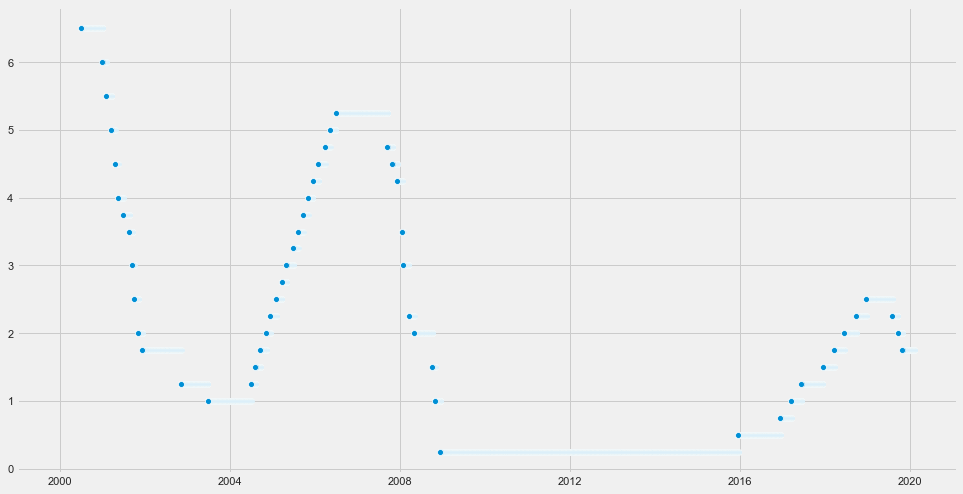

In [12]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2020.

So, again download from FRB of St. Louis (https://fred.stlouisfed.org/categories/118).

In [13]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARL.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARU.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.250
1982-09-28,10.250
1982-09-29,10.250
1982-09-30,10.250
1982-10-01,10.000
1982-10-02,10.000
1982-10-03,10.000
1982-10-04,10.000
1982-10-05,10.000


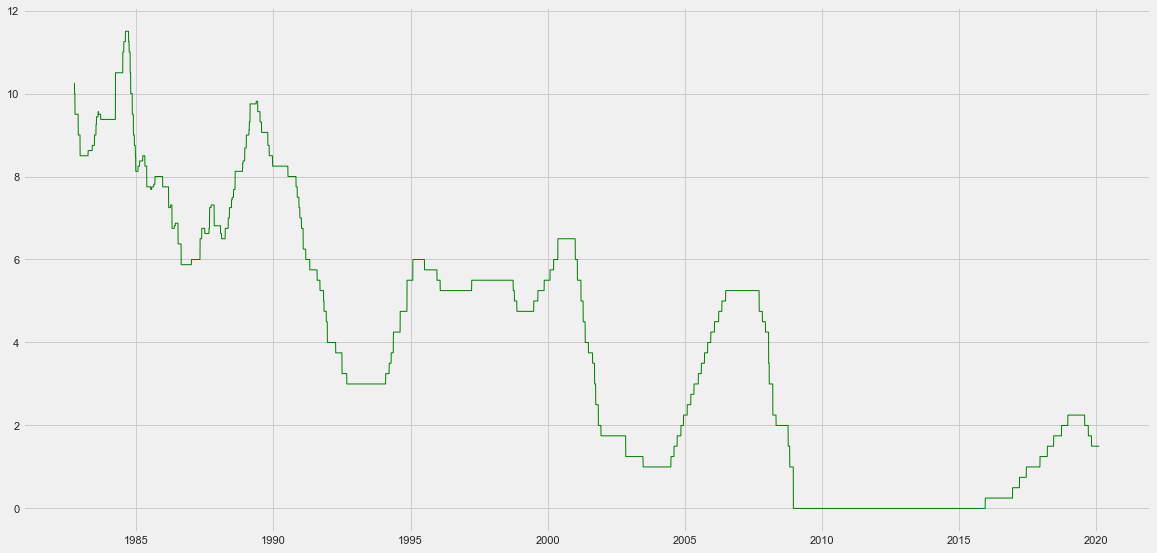

In [14]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Map Rate Decisions to Statements

In [72]:
statements['RateChange'] = None
statements['Rate'] = None

for i in range(len(statements)):
    for j in range(len(fedrate_df)):
        if statements.index[i] == fedrate_df.index[j]:
            statements['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 2
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 0

statements.head(10)

,contents,RateChange,Rate
Date,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25
1994-03-22,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75
1994-05-17,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75
1994-11-15,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,5.5
1995-02-01,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,2,6
1995-07-06,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",0,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,0,5.5


In [73]:
statements.tail(10)

,contents,RateChange,Rate
Date,,,
2019-01-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,2.25
2019-03-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,2.25
2019-05-01,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,2.25
2019-06-19,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,2.25
2019-07-31,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0,2
2019-09-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0,1.75
2019-10-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,1.75
2019-10-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0,1.5
2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,1.5


Looks good.
### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [74]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.
qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
          "to purchase the direct obligations of housing-related government-sponsored "\
          "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
          "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
          "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
          "have widened appreciably of late.  This action is being taken to reduce the cost "\
          "and increase the availability of credit for the purchase of houses, which in turn "\
          "should support housing markets and foster improved conditions in financial markets "\
          "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
          "the program will be conducted with the Federal Reserve's primary dealers through "\
          "a series of competitive auctions and will begin next week.  Purchases of up to "\
          "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
          "process with a goal of beginning these purchases before year-end.  "\
          "Purchases of both direct obligations and MBS are expected to take place over "\
          "several quarters.  Further information regarding the operational details of this "\
          "program will be provided after consultation with market participants."
statements = statements.append(
    pd.Series([qe_text, 0, 0], index=statements.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)
statements.sort_index(inplace=True)

# Add the other times when additional quantitative measures were announced in the statement
statements.loc['2009-03-18', 'RateChange'] = 0
statements.loc['2010-11-03', 'RateChange'] = 0
statements.loc['2011-09-21', 'RateChange'] = 0
statements.loc['2012-06-20', 'RateChange'] = 0
statements.loc['2012-09-13', 'RateChange'] = 0

# It was announced QE ends
statements.loc['2013-12-18', 'RateChange'] = 2

statements.iloc[statements.index > dt.datetime.strptime('2008-11-20', '%Y-%m-%d')]

,contents,RateChange,Rate
Date,,,
2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",0,0
2008-12-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0,0
2009-01-28,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0
2009-03-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0,0
2009-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0
2009-06-24,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0
2009-08-12,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0
2009-09-23,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0
2009-11-04,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,0


## Statements DataFrame

In [75]:
# Reorganize the dataframe
statement_df = pd.DataFrame(statements["contents"])
statement_df["contents_org"] = statement_df["contents"]
statement_df["target"] = statements["RateChange"]
statement_df["rate"] = statements["Rate"]
statement_df["stmt_date"] = statements.index
statement_df["type"] = "statement"
statement_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(statement_df)
separate_sections(statement_df)
add_word_count(statement_df)
statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,contents,contents_org,target,rate,stmt_date,type,contents_list,word_count
Date,,,,,,,,
1994-02-04,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,1994-02-04,statement,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",103
1994-03-22,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,3.5,1994-03-22,statement,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",165
1994-04-18,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,1994-04-18,statement,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",39
1994-05-17,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,4.25,1994-05-17,statement,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Committee decided t...",144
1994-08-16,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,1994-08-16,statement,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",142
1994-11-15,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,5.5,1994-11-15,statement,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",42
1995-02-01,[SECTION]For immediate release[

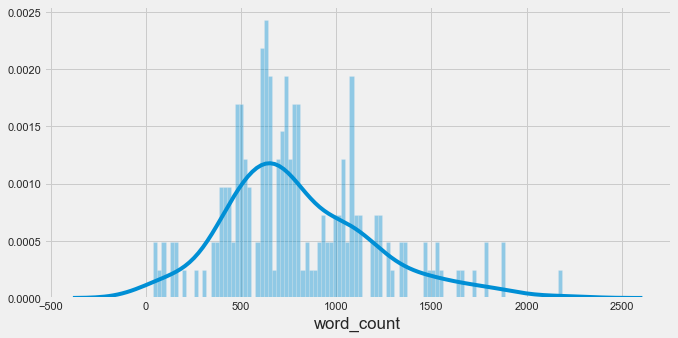

In [76]:
plt.figure(figsize=(10,5))
sns.distplot(statement_df["word_count"], bins=100)

In [77]:
remove_short_section(statement_df)

statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: S

,contents,contents_org,target,rate,stmt_date,type,contents_list,word_count
Date,,,,,,,,
1994-02-04,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,1994-02-04,statement,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",99
1994-03-22,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,3.5,1994-03-22,statement,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",57
1994-04-18,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,1994-04-18,statement,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",37
1994-05-17,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,4.25,1994-05-17,statement,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Committee decided t...",121
1994-08-16,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,1994-08-16,statement,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",51
1994-11-15,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,5.5,1994-11-15,statement,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",40
1995-02-01,Chairman Alan Greenspan announ

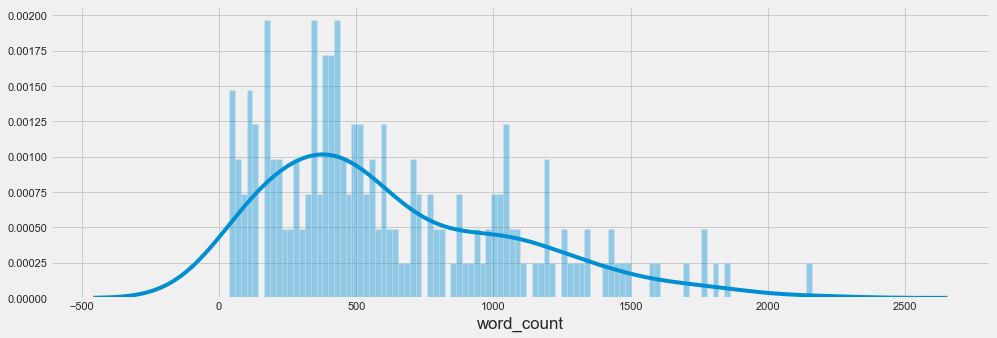

In [78]:
plt.figure(figsize=(15,5))
sns.distplot(statement_df["word_count"], bins=100)

### Split contents to max 200 words

In [79]:
stmt_split_df = get_split_df(statement_df)
stmt_split_df.tail()

,contents,target,rate,stmt_date,type
722,"Consistent with its January 2019 Statement Regarding Monetary Policy Implementation and Balance Sheet Normalization, the Committee reaffirms its intention to implement monetary policy in a regime ...",0,1.5,2019-10-30,statement
723,"stands ready to adjust the details of these plans as necessary to foster efficient and effective implementation of monetary policy.""Effective October 15, 2019, the Federal Open Market Committee di...",0,1.5,2019-10-30,statement
724,"that could adversely affect policy implementation. In addition, the Committee directs the Desk to conduct overnight reverse repurchase operations (and reverse repurchase operations with maturities...",0,1.5,2019-10-30,statement
725,Information received since the Federal Open Market Committee met in October indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains ...,1,1.5,2019-12-11,statement
726,Information received since the Federal Open Market Committee met in December indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains...,1,1.5,2020-01-29,statement


## Minutes DataFrame

In [80]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'
minutes_df.head()

,contents
Date,
1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."


In [81]:
print(minutes_df["contents"][-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

In [82]:
minutes_df["contents_org"] = minutes_df["contents"]
minutes_df['rate'] = minutes_df.index.map(get_rate)
minutes_df['target'] = minutes_df.index.map(get_rate_change)
minutes_df['stmt_date'] = minutes_df.index.map(get_statement_date)
minutes_df["type"] = "minutes"
minutes_df.dropna(inplace=True, axis=0, subset=['target'])

remove_return_code(minutes_df)
separate_sections(minutes_df)
add_word_count(minutes_df)
minutes_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,contents,contents_org,rate,target,stmt_date,type,contents_list,word_count
Date,,,,,,,,
1994-02-04,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Thursday, February 3, 1994, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",3.25,2.0,1994-02-04,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Thursday, February 3, 1994, at 2:30 ...",10355
1994-03-22,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, November 16, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, November 16, 1993, a...",3.50,2.0,1994-03-22,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, November 16, 1993, at 9:00 ...",6058
1994-03-22,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, December 21, 1993, at 9:00 a.m.[...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 21, 1993, at 9:...",3.50,2.0,1994-03-22,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, December 21, 1993, at 9:00 a.m....",5913
1994-05-17,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m.[SEC...","A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",4.25,2.0,1994-05-17,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m., P...",6456
1994-07-06,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30 ...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",4.75,2.0,1994-08-16,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30...",6736
1994-08-16,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, November 15, 1994, at 9:00 a.m.[...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, November 15, 1994, at 9:...",4.75,2.0,1994-08-16,minutes,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, November 15, 1994, at 9:00 a.m....",5603
1994-09-27,"A meeting of the Federal Open Market Committee was held in the offices of the Board

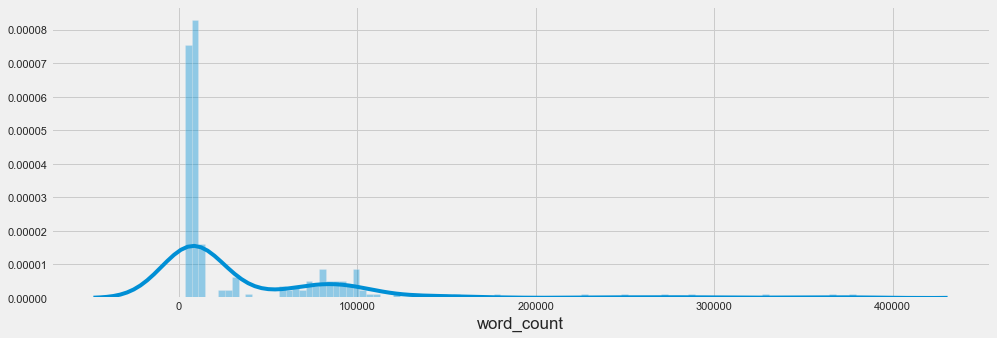

In [83]:
plt.figure(figsize=(15,5))
sns.distplot(minutes_df["word_count"], bins=100)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


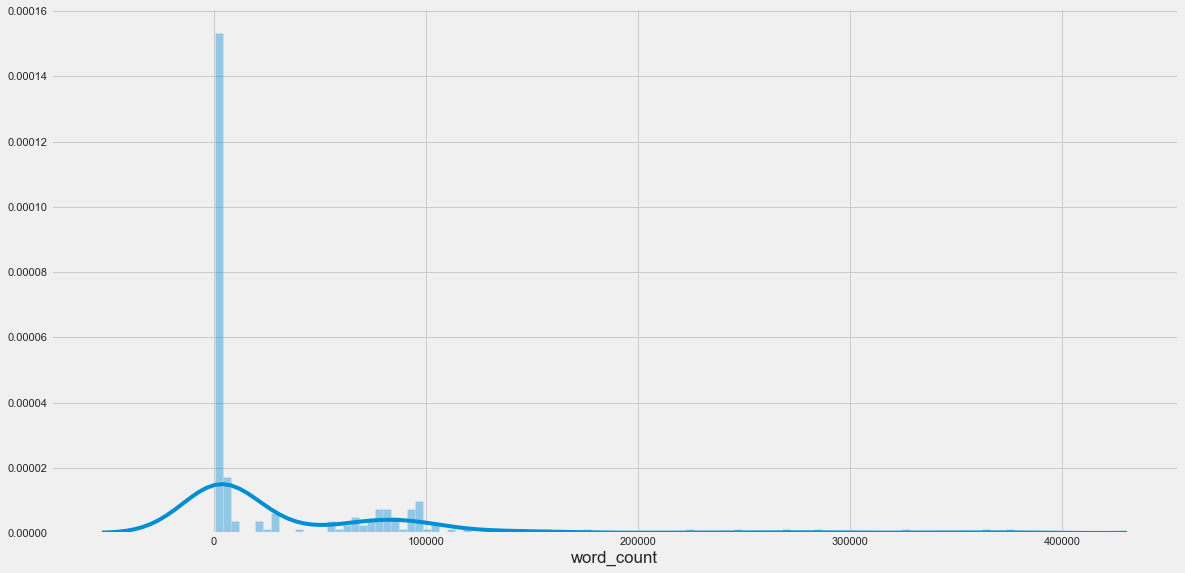

In [84]:
remove_short_section(minutes_df, 150)
sns.distplot(minutes_df["word_count"], bins=100)

### Split contents to max 200 words

In [85]:
minutes_split_df = get_split_df(minutes_df)
minutes_split_df.tail()

,contents,target,rate,stmt_date,type
52820,"ensure that the supply of reserves remains ample even during periods of sharp increases in non-reserve liabilities, and to mitigate the risk of money market pressures that could adversely affect p...",1.0,1.5,2019-12-11,minutes
52821,level that prevailed in early September. Some others suggested moving to an even higher level of reserves to provide an extra buffer and greater assurance of control over the federal funds rate. I...,1.0,1.5,2019-12-11,minutes
52822,"to monitor money market developments and stand ready to adjust the plan as necessary. Overall, participants agreed that the pace of purchases as well as the parameters of the repo operations were ...",1.0,1.5,2019-12-11,minutes
52823,as not to surprise market participants or lead them to infer that the Committee regarded the situation as dire and thus requiring immediate action. The Chair proposed having the staff produce a dr...,1.0,1.5,2019-12-11,minutes
52824,"banks' liquidity risk management while reducing the demand for reserves. Other participants, instead, highlighted that policy implementation had worked well with larger quantities of reserves and ...",1.0,1.5,2019-12-11,minutes


## Script DataFrame

In [86]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
script_df.head()

,contents
Date,
1990-02-07,"CHAIR YELLEN. Good afternoon. Earlier today, the Federal Open Market Committee ¼ to ½ percent. This action marks the end of an extraordinary seven-year period during which the federal funds rate..."
1990-03-27,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentlemen?\n\n[SEC...
1990-05-15,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there a seco..."
1990-07-03,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there a sec..."
1990-08-21,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\nCHAIRMAN GREE...


In [87]:
script_df['contents'][2]

'CHAIRMAN GREENSPAN. Good morning, everyone. We\'ll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there a second?\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Without objection. Sam Cross.\n\n[SECTION]\n\nMR. CROSS. [Statement--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for Sam?\n\n[SECTION]\n\nMR. HOSKINS. Sam, was the unwinding of the DM warehousingrelated to any collateral problems that we have with respect to notes?Why did the Treasury do that? What reason did the Treasury give?\n\n[SECTION]\n\nMR. CROSS. Well, I think the Treasury is interested, as weare, in not having these [warehousing] amounts continue indefinitelyand be too big. So, when the conditions were such that it waspossible to make some arrangements in order to bring those holdingsdown, they were not reluctant or hesitant to do this. It\'s notenvisaged as a continuous or perpetual facilit

In [88]:
script_df["contents_org"] = script_df["contents"]
script_df['rate'] = script_df.index.map(get_rate)
script_df['target'] = script_df.index.map(get_rate_change)
script_df['stmt_date'] = script_df.index.map(get_statement_date)
script_df["type"] = "script"
script_df.dropna(inplace=True, axis=0, subset=['target'])

remove_return_code(script_df)
separate_sections(script_df)
add_word_count(script_df)
remove_short_section(script_df, 50)

script_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,contents,contents_org,rate,target,stmt_date,type,contents_list,word_count
Date,,,,,,,,
1994-02-04,"MR. BERNARD.Secretary and Economist, Donald Kohn;Deputy Secretary, Normand Bernard;Assistant Secretaries, Joseph Coyne and Gary Gillum;General Counsel, J. Virgil Mattingly;Deputy General Counsel, ...","CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nomi...",3.25,2.0,1994-02-04,script,"[CHAIRMAN GREENSPAN. As you know, this is our organizationalmeeting and always in such meetings we have the election of theChairman and Vice Chairman. I turn to our senior Board member tooffer nom...",25054
1994-03-22,"MR. FISHER. There were some days on which the criticism ofhedge funds or leveraged funds or derivatives worsened the impact.That impact wasn't very long-lived, but there were a few days whencommen...","CHAIRMAN GREENSPAN. Good morning everyone. We welcome CathyMinehan.\n\n[SECTION]\n\nMS. MINEHAN. Thank you, Mr. Chairman.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. I trust you won't dominate the meeting...",3.50,2.0,1994-03-22,script,"[CHAIRMAN GREENSPAN. Good morning everyone. We welcome CathyMinehan., MS. MINEHAN. Thank you, Mr. Chairman., CHAIRMAN GREENSPAN. I trust you won't dominate the meetingbut if you do, so be it!, MS....",27648
1994-05-17,"MR. BROADDUS. Peter, you mentioned communication. Most ofthe research I've seen suggests that intervention like this, if it hasan effect, it's mainly by way of communicating future likely policyac...",CHAIRMAN GREENSPAN. Would somebody like to open the meetingby making a motion to approve the minutes?\n\n[SECTION]\n\nVICE CHAIRMAN MCDONOUGH. So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is there...,4.25,2.0,1994-05-17,script,"[CHAIRMAN GREENSPAN. Would somebody like to open the meetingby making a motion to approve the minutes?, VICE CHAIRMAN MCDONOUGH. So move., CHAIRMAN GREENSPAN. Is there a second?, SPEAKER(?). Secon...",17429
1994-07-06,"CHAIRMAN GREENSPAN. And my next news--the unwelcome news--isthat Si Keehn is leaving and this is his final meeting. It says herethat his first meeting was on July 6, 1981. Si, of course, willretur...","CHAIRMAN GREENSPAN. Before we get started on our formalproceedings, I have several announcements. First, we'd like towelcome the new Vice Chairman of the Federal Reserve Board to hisfirst Federal ...",4.75,2.0,1994-08-16,script,"[CHAIRMAN GREENSPAN. Before we get started on our formalproceedings, I have several announcements. First, we'd like towelcome the new Vice Chairman of the Federal Reserve Board to hisfirst Federal...",34456
1994-08-16,"VICE CHAIRMAN MCDONOUGH. It is my pleasure, Mr. Chairman, tomove the election of Frederic Mishkin as associate economist. Rick,as he is known to his friends, has just joined the Federal ReserveBan...",CHAIRMAN GREENSPAN. Who would like to move approval of theminutes for the August meeting?\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPA...,4.75,2.0,1994-08-16,script,"[CHAIRMAN GREENSPAN. Who would like to move approval of theminutes for the August meeting?, SPEAKER(?). So move., SPEAKER(?). Second., CHAIRMAN GREENSPAN. Without objection they are approved.Presi...",20232
1994-09-27,CHAIRMAN GREENSPAN. On that thereare two ongoing thoughts that are supposed to be insights into whathappened. First is the notion that the moves on the part of those twocentral banks were suggesti...,"CHAIRMAN GREENSPAN. Before we get under way today, I want towelcome Governor Janet Yellen who is attending her first Committeemeeting.\n\n[SECTION]\n\nMS. YELLEN. Thank you.\n\n[SECTION]\n\nCHAIRM...",5.50,2.0,1994-11-15,script,"[CHAIRMAN GREENSPAN. Before we get under way today, I want towelcome Governor Janet Yellen who is attending her first Committeemeeting., MS. YELLEN. Thank you., CHAIRMAN GREENSPAN. She was exposed...",17409
1994-11-15,"CHAIRM

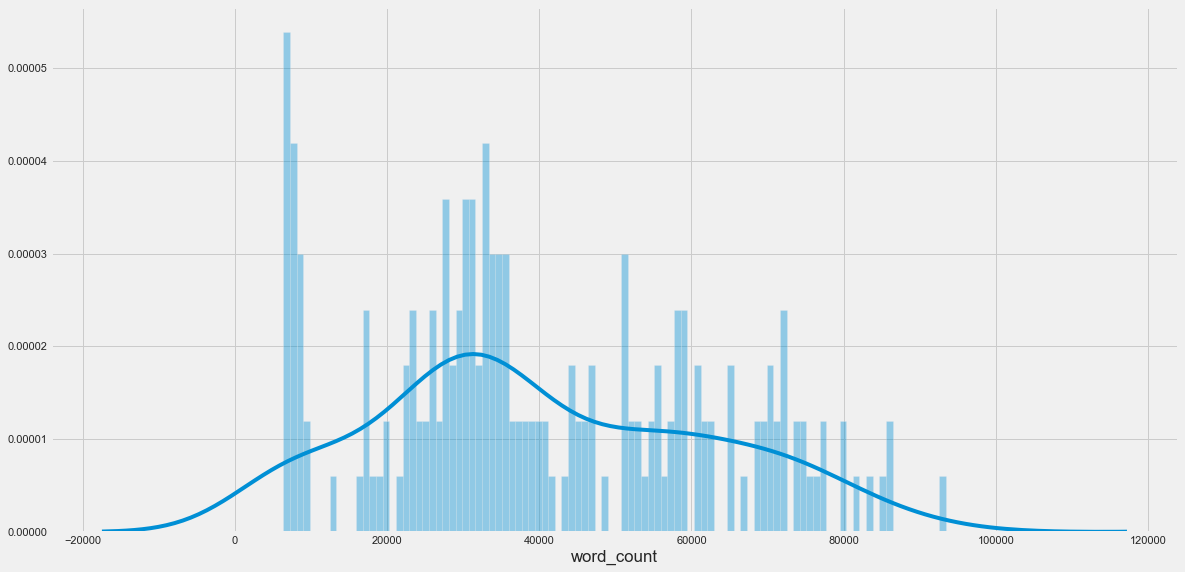

In [89]:
sns.distplot(script_df["word_count"], bins=100)

### Split contents to max 200 words

In [90]:
script_split_df = get_split_df(script_df)
script_split_df.tail()

,contents,target,rate,stmt_date,type
50748,"say that I think this is a good time to do—to update CRA, really, in a way that is a win–win both for the intended beneficiaries—low- and moderate-income communities—and also for banks that would ...",1.0,1.5,2020-01-29,script
50749,We spent a lot of time on research and analysis and looking at meaningful reform. You saw Governor Brainard’s recent speech presenting some of the thinking and the analysis. And we haven’t made an...,1.0,1.5,2020-01-29,script
50750,It’s about the views of the interested parties. HANNAH LANG. Hannah Lang with American Banker. Thank you for being here today. I wanted to ask about Vice Chair Quarles’s recent speech on bank supe...,1.0,1.5,2020-01-29,script
50751,"the—he’s raising some very interesting questions about, if you—in the first part of the speech, where he’s talking about regulation and supervision and, you know, how to—how to balance the desire ...",1.0,1.5,2020-01-29,script
50752,"again cutting rates, eroding their ability to get a higher return on their savings? And how much would you take their plight into consideration? How much can you sympathize with them? CHAIR POWELL...",1.0,1.5,2020-01-29,script


## Speech DataFrame

In [91]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
speech_df

,contents
Date,
1996-06-13,"Remarks on the ""Millennium Bug""\n\r\n\tI am pleased to appear before the Professional Banker's Association to discuss the Millennium Bug from a public sector perspective. The Millennium Bug, or Y..."
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n\n\n\n\n\n\r\n\r\n\r\n ..."
1996-09-08,Monetary Policy Objectives and Strategy\n\r\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to ...
1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
1996-10-02,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n\n\n\n\n\n\r\n ..."
1996-10-05,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
1996-10-07,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n\n\n\n\n\nSmall Business Is Big Business\n\r\n It is my pleasu..."
1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n\n\n\n\n\nHere We Go Again?\n\r\n\tThank you. It is a pleasure to b..."
1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n\n\n\n\n\nHow To Grow Faster\n\r\n It is my pleasure to be here today to dis..."


In [92]:
speech_df["contents_org"] = speech_df["contents"]
speech_df['rate'] = speech_df.index.map(get_rate)
speech_df['target'] = speech_df.index.map(get_rate_change)
speech_df['stmt_date'] = speech_df.index.map(get_statement_date)
speech_df["type"] = "speech"
speech_df.dropna(inplace=True, axis=0, subset=['target'])

remove_return_code(speech_df)
separate_sections(speech_df)
add_word_count(speech_df)
remove_short_section(speech_df, 50)

speech_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,contents,contents_org,rate,target,stmt_date,type,contents_list,word_count
Date,,,,,,,,
1996-06-13,"Remarks on the ""Millennium Bug""\tI am pleased to appear before the Professional Banker's Association to discuss the Millennium Bug from a public sector perspective. The Millennium Bug, or Year 20...","Remarks on the ""Millennium Bug""\n\r\n\tI am pleased to appear before the Professional Banker's Association to discuss the Millennium Bug from a public sector perspective. The Millennium Bug, or Y...",5.5,2.0,1997-03-25,speech,"[Remarks on the ""Millennium Bug""\tI am pleased to appear before the Professional Banker's Association to discuss the Millennium Bug from a public sector perspective. The Millennium Bug, or Year 2...",35460
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996 It is a pleasure to be here this ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n\n\n\n\n\n\r\n\r\n\r\n ...",5.5,2.0,1997-03-25,speech,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996 It is a pleasure to be here this...",28674
1996-09-08,Monetary Policy Objectives and StrategyI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphas...,Monetary Policy Objectives and Strategy\n\r\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to ...,5.5,2.0,1997-03-25,speech,[Monetary Policy Objectives and StrategyI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to empha...,43853
1996-09-19,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996 ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",5.5,2.0,1997-03-25,speech,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996 ...",11973
1996-10-02,"Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996 You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n\n\n\n\n\n\r\n ...",5.5,2.0,1997-03-25,speech,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996 You may well wonder why ...",14900
1996-10-05,"Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yor...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",5.5,2.0,1997-03-25,speech,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...",6324
1996-10-07,"Remarks by Governor Lawrence B. LindseyAt the Small Business Dev

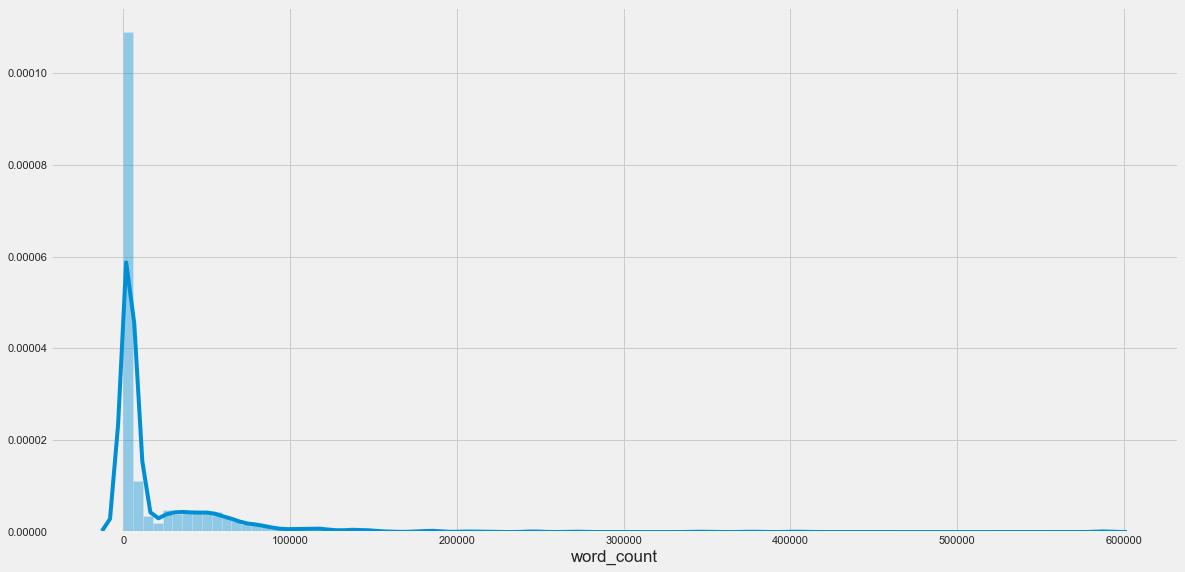

In [93]:
sns.distplot(speech_df["word_count"], bins=100)

### Split contents to max 200 words

In [ ]:
# speech_split_df = get_split_df(speech_df)
# speech_split_df.tail()

## Combine DataFrames and Save

In [94]:
frames = [statement_df, minutes_df, script_df, speech_df]

df = pd.concat(frames, sort=True)
one_hot_encode(df)
df.reset_index(inplace=True, drop=True)
df.drop(columns=['contents_list', 'contents_org'], inplace=True)
df.rename(columns={'contents': 'text'}, inplace=True)

df.head()

,text,rate,stmt_date,target,type,word_count,target_lower,target_hold,target_raise
0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,3.25,1994-02-04,2,statement,99,0,0,1
1,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",3.5,1994-03-22,2,statement,57,0,0,1
2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,3.75,1994-04-18,2,statement,37,0,0,1
3,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...",4.25,1994-05-17,2,statement,121,0,0,1
4,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",4.75,1994-08-16,2,statement,51,0,0,1


In [95]:
with open("../data/FOMC/train_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_df.csv', index=True)

In [96]:
split_frame = [stmt_split_df, minutes_split_df, script_split_df]

split_df = pd.concat(split_frame, ignore_index=True, sort=True)
one_hot_encode(split_df)
split_df['target'] = split_df['target'].map(lambda x: int(x))
add_word_count(split_df)
split_df.rename(columns={'contents': 'text'}, inplace=True)

split_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,text,rate,stmt_date,target,type,target_lower,target_hold,target_raise,word_count
0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,3.25,1994-02-04,2,statement,0,0,1,99
1,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",3.50,1994-03-22,2,statement,0,0,1,57
2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,3.75,1994-04-18,2,statement,0,0,1,37
3,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.These measures were taken against...",4.25,1994-05-17,2,statement,0,0,1,121
4,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",4.75,1994-08-16,2,statement,0,0,1,51


In [97]:
with open("../data/FOMC/train_split_df.pickle", "wb") as file:
    pickle.dump(split_df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_split_df.csv', index=True)